In [35]:
import h5py
import numpy as np
import os
import math
import scipy
import time
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from numpy.random import shuffle
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

print(os.listdir("Path/Asm1/Input"))

['.DS_Store', 'test', 'train']


In [3]:
with h5py.File('Path/Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('Path/Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
with h5py.File('Path/Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])[:2000,:]
with h5py.File('Path/Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

Showing a sample data. The first example belongs to class 0: T-Shirt/Top

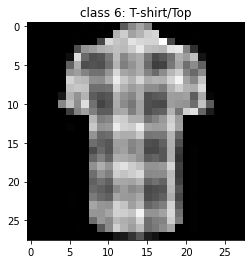

In [116]:
import matplotlib.pyplot as plt
data_train = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(data_train[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
plt.show()

In [117]:
data_train = data_train.reshape((data_train.shape[0], -1))
print(data_train.shape) 

(30000, 784)


<font size=5 color=#000000> SVD

In [38]:
r_svd = 400

In [39]:
U,Sing,Vt = np.linalg.svd(data_train)

In [40]:
#test code
S = np.diag(Sing)

In [123]:
svd_train = U[0:U.shape[0], 0:r_svd].dot(S[0:r_svd, 0:r_svd]).dot(Vt[0:r_svd,0:Vt.shape[1]])

In [42]:
U2,Sing2,Vt2 = np.linalg.svd(data_test)
S2 = np.diag(Sing2)

In [124]:
svd_test = U2[0:U2.shape[0], 0:r_svd].dot(S2[0:r_svd, 0:r_svd]).dot(Vt2[0:r_svd,0:Vt2.shape[1]])

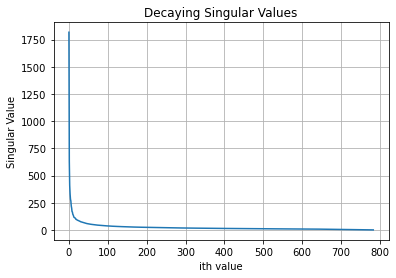

In [38]:
#find a good r_svd
fig, ax = plt.subplots()
ax.plot([i for i in range(784)], Sing)
ax.set_xlabel('ith value')
ax.set_ylabel('Singular Value')
ax.set_title('Decaying Singular Values')
plt.grid(True)
plt.show()

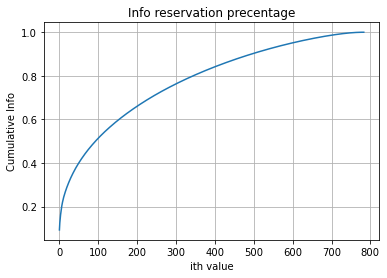

In [42]:
##find a good r_svd
fig, ax = plt.subplots()
SEachSum = [Sing[:i+1,].sum() for i in range(784)]
STotalSum = np.sum(Sing)
ax.plot([i for i in range(784)], [SEachSum[i]/STotalSum for i in range(784)])
ax.set_xlabel('ith value')
ax.set_ylabel('Cumulative Info')
ax.set_title('Info reservation precentage')
plt.grid(True)
plt.show()

In [49]:
#check
print((svd_train==data_train).all())

False


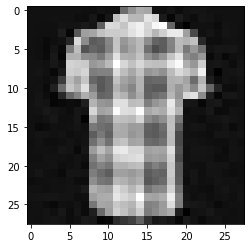

In [125]:
import matplotlib.pyplot as plt
temp = svd_train[0].reshape((28, 28))
plt.imshow(temp, cmap=plt.get_cmap('gray'))
plt.show()

<font size=5 color=#000000>PCA(Principal Component Analysis)

In [98]:
#find a reasonable n_components (not recommended)
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

# feature normalization (feature scaling)
X_scaler = StandardScaler()
x = X_scaler.fit_transform(svd_train)

# PCA
pca = PCA(n_components=0.9) #We want new dimensions to keep 90% information
x = pca.fit_transform(x)

print(x.shape)  #find one of the reasonable n_components is 82

(30000, 82)


In [6]:
n_components = 150

In [15]:
def PCA(new_d, data, meanVec):
    stdData = data - meanVec          #the new mean for each column is 0
    covMatrix = np.cov(stdData, rowvar = False) #covariance matrix
    eigVal, eigVec = np.linalg.eig(np.mat(covMatrix))
    eigVec = eigVec[:,np.argsort(-eigVal)][:new_d,:]  #take eigenvectors corresponding to the first new_d largest eigenvalues
    eigVal = -np.sort(-eigVal)[:new_d] #sort eigenvalue
    data_pca = stdData.dot(eigVec.T) #mapping the original dataset onto the new eigen space
    return data_pca, eigVal ,eigVec

In [11]:
mean_train = np.mean(data_train, axis = 0) #mean for each column of training

In [16]:
pca_train, eVa_train, eVe_train = PCA(n_components, data_train, mean_train)

In [17]:
pca_test = (data_test - mean_train) @ eVe_train.T

In [38]:
pca_train = pca_train.A
pca_test = pca_test.A

In [18]:
print(pca_test.shape)
print(eVe_train.shape)

(2000, 150)
(150, 784)


<font size=5 color=blue> KNN

In [17]:
def KNN(test, training, train_label, k):
    size = training.shape[0]
    diffMat  = np.tile(test, (size, 1)) - training
    squareMat = diffMat ** 2
    dist = squareMat.sum(axis = 1)
    dist = dist ** 0.5
    sortedDist = dist.argsort()
    classvote = {}
    
    for i in range(k):
        LabelI = train_label[sortedDist[i]]
        classvote[LabelI] = classvote.get(LabelI, 0) + 1
    sortedVote = sorted(classvote.items(), key=lambda item:item[1], reverse=True)
    return sortedVote[0][0]

In [18]:
#test code
temp = np.array([[1.0, 0.8], [1.0, 1.0], [0, 0], [0, 0.1], [0.8, 0.9], [0.3, 0.15]]) 
templabels = ['A', 'A', 'B', 'B', 'A', 'B']
testFinal = KNN([0.1, 0.2], temp, templabels, 2)
print(testFinal) #should return class B

B


In [24]:
K = 15 #you may use the cross validation (will be updated in few days) to set up this hyper-parameter

In [25]:
prdLabels = []
for i in range(pca_test.shape[0]):
    predicted = KNN(pca_test[i].A, pca_train.A, label_train, K)
    prdLabels.append(predicted)

In [61]:
def computeAccuracy(predictList, label):
    correctCount = 0
    for i in range(label.shape[0]):
        if predictList[i] == label[i]:
            correctCount = correctCount + 1
    return correctCount/float(label.shape[0])

In [27]:
computeAccuracy(prdLabels, label_test) 

0.8195

<font size=5 color=Orange> Naive Bayes

In [105]:
def normalize(image): #Image pixel binarization
    m=image.shape[0]
    n=np.array(image).shape[1]
    for i in range(m):
        for j in range(n):
            if image[i,j] != 0:
                image[i,j] = 1
            else:
                image[i,j] = 0
    return image

In [33]:
def model_training(trainset, trainlabel, classNum):
    m = trainset.shape[0] #the number of images:30000
    n = trainset.shape[1] #the number of features: 784
    prior_prob = np.zeros(classNum) #class prior
    cdt_prob = np.zeros((classNum, n, 2)) #conditional density 
            #the data structure storing the probability that each pixel of the image given the class is black or white
    
    for i in range(m): 
        img = trainset[i] #ith image
        label = trainlabel[i]
        prior_prob[label] += 1
        for j in range(n):
            temp = img[j].astype(int) #parse double to int
            cdt_prob[label][j][temp] += 1
    
    for i in range(classNum):
        for j in range(n):
            pixiv_0 = cdt_prob[i][j][0]
            pixiv_1 = cdt_prob[i][j][1]
            
            cdt_prob[i][j][0] = (float(pixiv_0)/float(pixiv_0 + pixiv_1)) * 10000 + 1 #smoothing
            cdt_prob[i][j][1] = (float(pixiv_1)/float(pixiv_0 + pixiv_1)) * 10000 + 1
    return prior_prob, cdt_prob

In [34]:
def compute_prob(img, label, prior_prob, cdt_prob):
    prob = int(prior_prob[label]) #class prior
    n = img.shape[0] #the number of features
    for i in range(n):
        prob *= int(cdt_prob[label][i][img[i].astype(int)]) 
    
    return prob

In [35]:
def predict(testset, testlabel, prior_prob, cdt_prob):
    predictlist=[]
    m = testset.shape[0] #2000
    n = testset.shape[1] #784
    for i in range(m):
        img = np.array(testset[i])
        label = testlabel[i]
        bestLabel = 0
        bestProb = compute_prob(img, 0, prior_prob, cdt_prob)
        for j in range(1, 10):
            prob = compute_prob(img, j, prior_prob, cdt_prob)
            if bestProb < prob:
                bestProb = prob
                bestLabel = j
        predictlist.append(bestLabel)
    
    return np.array(predictlist)

In [118]:
normalize(data_train)
normalize(data_test)
print('done')

done


In [119]:
prior_probability, conditional_probability = model_training(data_train, label_train, 10)

In [120]:
predictList = predict(data_test, label_test, prior_probability, conditional_probability)

In [121]:
computeAccuracy(predictList, label_test)

0.711

<font size=5 color=Green> Multi-Class Logistic Regression

Most of the following codes were provided in the lab with all the blank being filled.

In [4]:
def onehot_encode(label):
    onehot_label = np.zeros((label.size, label.max() + 1)) #create a zero matrix of size (samples, 10)
    onehot_label[np.arange(label.size), label] = 1 #Example: If ith label is 5, then matrix[i][label] = 1
    return onehot_label

In [5]:
label_val = onehot_encode(label_train)
print(label_val.shape)

(30000, 10)


In [43]:
#Find this formula on W8 lec material p21
def softmax(X):
    expX = np.exp(X)
    A = expX/expX.sum(axis = 1, keepdims = True) #sum along class probabilities for each sample, and the sum is two-dimensional
    return A

In [44]:
#X is datamatrix, y is one-hot label, W is weight and l is regularization paramaters
#Find the formula on W8 lec material p17
def softmax_loss(X, y, W, l):
    A = softmax(X.dot(W))
    size = X.shape[0]
    square_norm = np.linalg.norm(W)**2
    return -(np.sum(y * np.log(A)))/size + (l/2) * square_norm # * is not dot product but times the elements at same entry of two matrices

In [50]:
#The gradient function of the loss function
def softmax_gd(X, y, W, l):
    A = softmax(X.dot(W))
    size = X.shape[0]
    return (np.dot(X.T, (A - y))/size) + l * W

In [51]:
# building learning fuction using softmax gradient descent
def softmax_fit(X, y, W, l, lr = 0.01, nepoches = 100, tol = 1e-5, batch_size = 10):
    W_old = W.copy()
    ep = 0 
    loss_hist = [softmax_loss(X, y, W, l)] # store history of loss 
    N = X.shape[0]
    nbatches = int(np.ceil(float(N)/batch_size)) #the number of loss update steps per epoch
    while ep < nepoches: 
        ep += 1 
        mix_ids = np.random.permutation(N) # shuffle the data, return random permutation of numbers in [0,N-1] as indices
        for i in range(nbatches):
            # get the i-th batch
            batch_ids = mix_ids[batch_size*i:min(batch_size*(i+1), N)] 
            X_batch, y_batch = X[batch_ids], y[batch_ids]
            W -= lr * softmax_gd(X_batch, y_batch, W, l) #the core step for mini-batch gradient descent
                                                        #The formula in grey part on W8 lec material p17
        loss_hist.append(softmax_loss(X, y, W, l))
        if np.linalg.norm(W - W_old)/W.size < tol:
            break 
        W_old = W.copy()
    return W, loss_hist 

In [52]:
W_init = np.random.randn(pca_train.shape[1], len(label_val[1])) #ten models

In [56]:
type(pca_train)
W_init.shape
pca_train.shape

(30000, 150)

In [71]:
W, loss_hist = softmax_fit(pca_train, label_val, W_init, l = 0, batch_size = 100, nepoches = 1500, lr = 0.1)

In [72]:
def pred(W, X):
    A = softmax(X.dot(W)) #A size (2000, 10)
    return np.argmax(A, axis = 1) #find max probability for each test sample

In [73]:
y_pre = pred(W, pca_test)

In [74]:
computeAccuracy(y_pre, label_test)

0.6815

<font size=5 color=red> Output

In [ ]:
import numpy as np
with h5py.File('predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=output)

<div style="text-align: center"> $$\text{Accuracy} = \frac{\text{Number of correct classifications}}{\text{Total number of test examples used}} * 100\%$$